# Problem Statement:

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [96]:
df = pd.read_csv("temperature.csv",parse_dates=["Date"])
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   station           7750 non-null   float64       
 1   Date              7750 non-null   datetime64[ns]
 2   Present_Tmax      7682 non-null   float64       
 3   Present_Tmin      7682 non-null   float64       
 4   LDAPS_RHmin       7677 non-null   float64       
 5   LDAPS_RHmax       7677 non-null   float64       
 6   LDAPS_Tmax_lapse  7677 non-null   float64       
 7   LDAPS_Tmin_lapse  7677 non-null   float64       
 8   LDAPS_WS          7677 non-null   float64       
 9   LDAPS_LH          7677 non-null   float64       
 10  LDAPS_CC1         7677 non-null   float64       
 11  LDAPS_CC2         7677 non-null   float64       
 12  LDAPS_CC3         7677 non-null   float64       
 13  LDAPS_CC4         7677 non-null   float64       
 14  LDAPS_PPT1        7677 n

In [65]:
df.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

In [66]:
df[df["LDAPS_RHmin"].isnull()]

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
1025,1.0,2013-10-08,27.1,24.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.6046,126.991,212.3350,2.7850,5304.412598,31.4,22.3
1026,2.0,2013-10-08,29.7,25.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.6046,127.032,44.7624,0.5141,5162.595703,34.3,23.2
1027,3.0,2013-10-08,29.1,25.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5776,127.058,33.3068,0.2661,5157.235352,33.9,24.0
1028,4.0,2013-10-08,30.8,27.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.6450,127.022,45.7160,2.5348,5148.043945,34.9,24.5
1029,5.0,2013-10-08,29.7,25.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5507,127.135,35.0380,0.5055,5147.667969,32.9,23.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,21.0,2016-08-20,34.1,27.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5507,127.040,26.2980,0.5721,4795.120117,35.5,27.5
5946,22.0,2016-08-20,34.3,27.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5102,127.086,21.9668,0.1332,4782.181641,36.2,27.5
5947,23.0,2016-08-20,34.6,28.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5372,126.891,15.5876,0.1554,4783.152832,37.3,28.8
5948,24.0,2016-08-20,35.0,28.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.5237,126.909,17.2956,0.2223,4778.877930,37.0,28.7


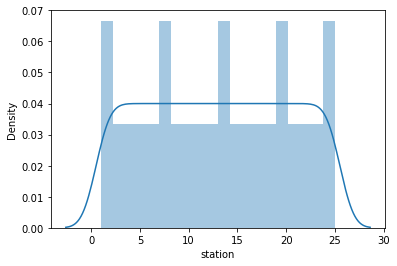

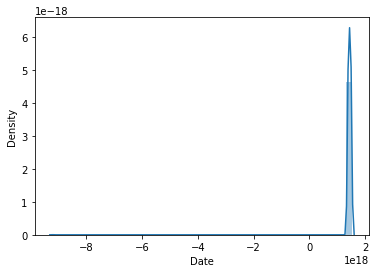

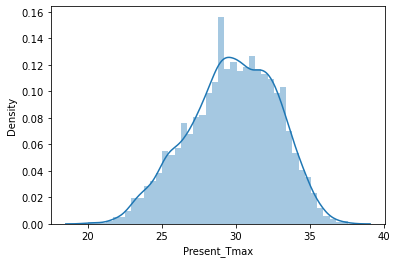

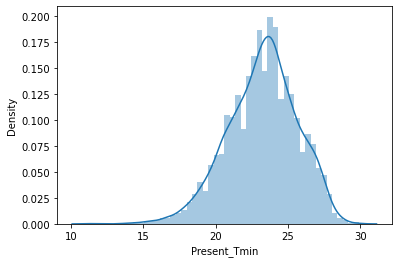

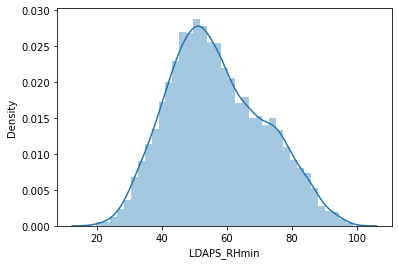

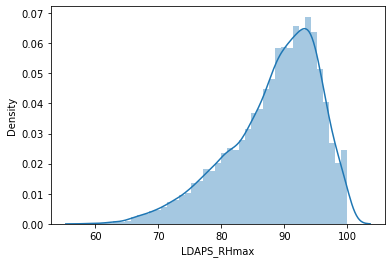

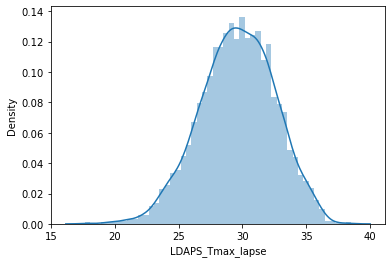

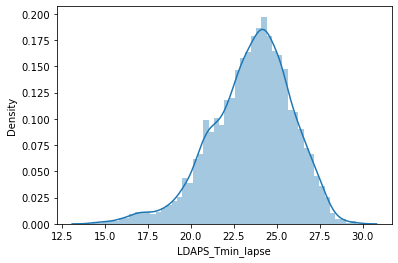

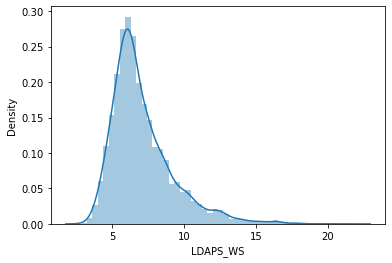

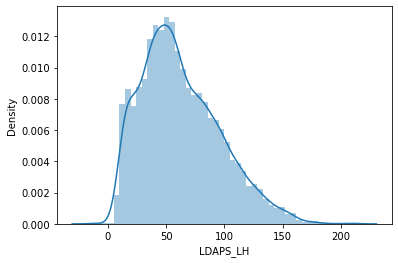

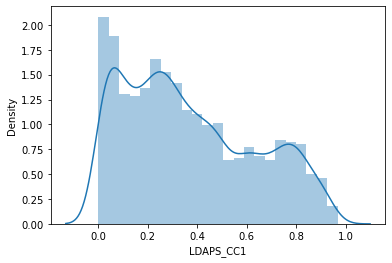

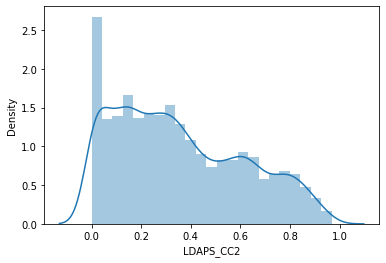

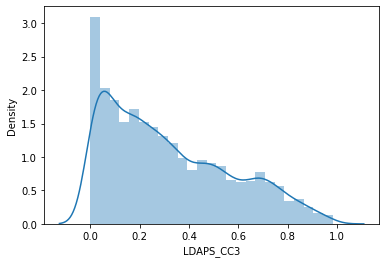

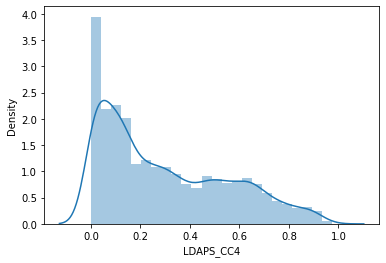

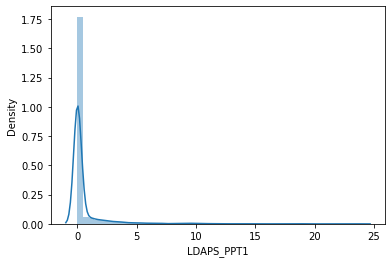

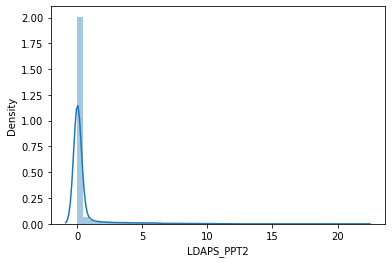

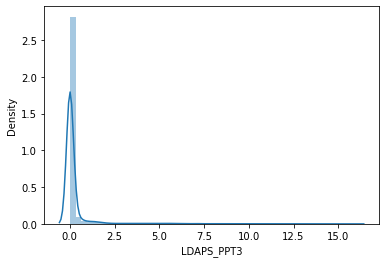

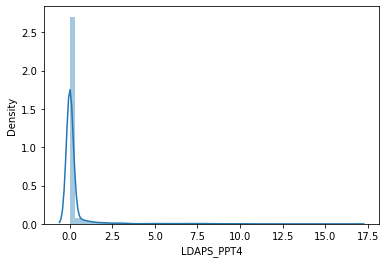

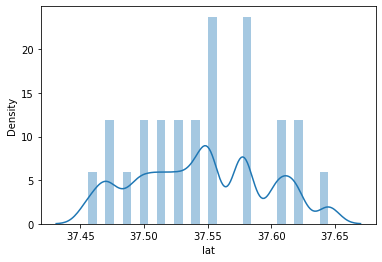

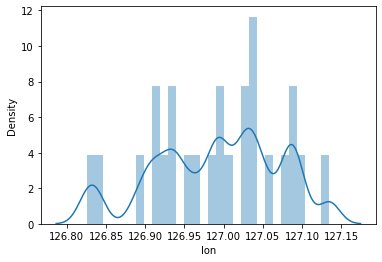

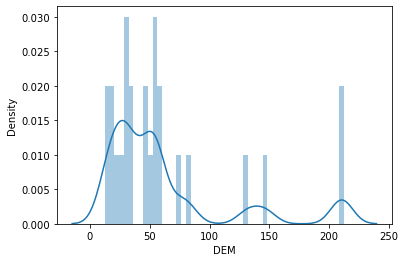

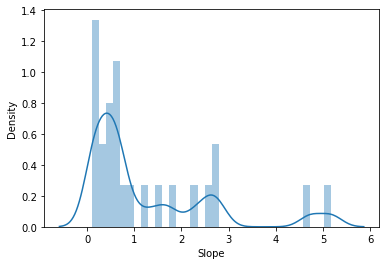

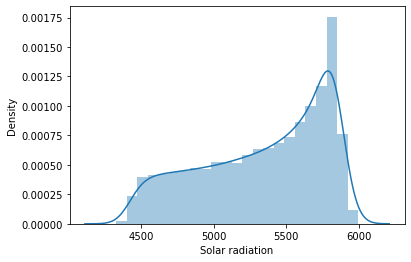

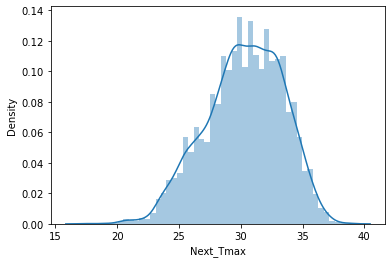

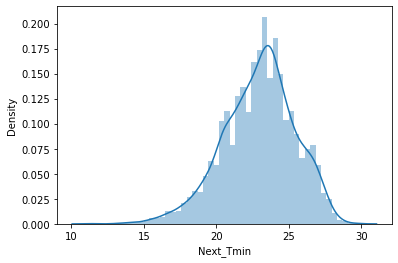

In [67]:
columns =['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']
for i in df[columns]:
    plt.figure()
    sns.distplot(df[i])

In [68]:
df = df.dropna(subset= ['LDAPS_RHmin','LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4'])

Most of the columns containing nan value in same raw . it almost 14 columns so drop th nan values . Other columns fill with mean

In [69]:
df["Present_Tmax"].fillna(df["Present_Tmax"].mean(),inplace=True)

In [70]:
df["Present_Tmin"].fillna(df["Present_Tmin"].mean(),inplace=True)

In [71]:
df["Next_Tmax"].fillna(df["Next_Tmax"].mean(),inplace=True)

In [72]:
df["Next_Tmin"].fillna(df["Next_Tmin"].mean(),inplace=True)

In [73]:
df.drop(columns=["station","Date"],inplace=True)

station and date are not requerd for prediction

In [74]:
df.isnull().sum()

Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

(array([  4.,   4.,   0.,   3.,   6.,  16.,   9.,  30.,  33.,  70.,  63.,
         74.,  70., 112., 119., 183., 126., 174., 147., 213., 169., 272.,
        219., 321., 262., 394., 377., 359., 376., 284., 363., 243., 380.,
        269., 346., 253., 294., 200., 229., 135., 147.,  98.,  88.,  43.,
         47.,  24.,  11.,  10.,   4.,   4.]),
 array([20.   , 20.352, 20.704, 21.056, 21.408, 21.76 , 22.112, 22.464,
        22.816, 23.168, 23.52 , 23.872, 24.224, 24.576, 24.928, 25.28 ,
        25.632, 25.984, 26.336, 26.688, 27.04 , 27.392, 27.744, 28.096,
        28.448, 28.8  , 29.152, 29.504, 29.856, 30.208, 30.56 , 30.912,
        31.264, 31.616, 31.968, 32.32 , 32.672, 33.024, 33.376, 33.728,
        34.08 , 34.432, 34.784, 35.136, 35.488, 35.84 , 36.192, 36.544,
        36.896, 37.248, 37.6  ]),
 <BarContainer object of 50 artists>)

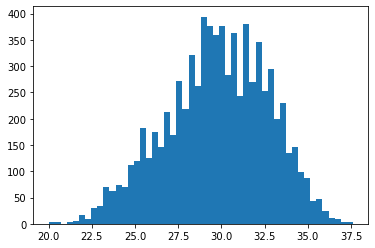

In [75]:
plt.hist(x=df["Present_Tmax"],bins=50)

<AxesSubplot:>

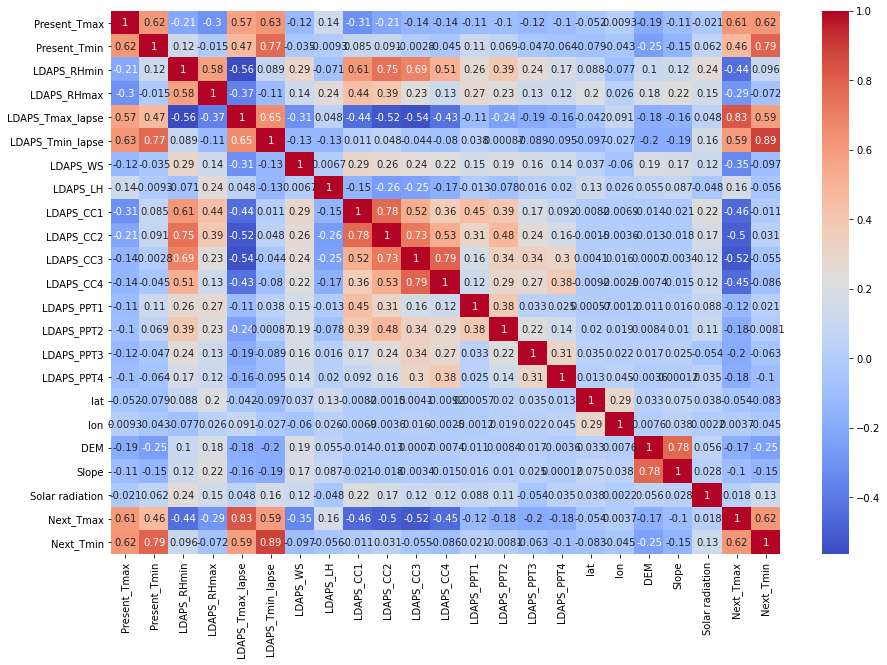

In [76]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True ,cmap="coolwarm")

LDAPS_Tmax_lapse and LDAPS_Tmin_lapse are highly correlated with each other and also highly correlated with target variables.

In [77]:
df.describe()

,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,...,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000
mean,29.746799,23.195622,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,0.356080,...,0.485003,0.278200,0.269407,37.544722,126.991397,61.868100,1.257052,5343.632222,30.237464,22.910157
std,2.956131,2.393700,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,0.258061,...,1.762807,1.161809,1.206214,0.050352,0.079435,54.280038,1.370450,429.990083,3.110297,2.480583
min,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,0.140615,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,5002.308105,28.200000,21.300000
50%,29.900000,23.300000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,0.312421,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5441.393066,30.400000,23.100000
75%,32.000000,24.800000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,0.558694,...,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5729.839844,32.600000,24.600000
max,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,0.968353,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


most of the column mean and median are near by value. 75% and maximum value also have similar case as mean median

In [78]:
df.skew()

Present_Tmax       -0.258580
Present_Tmin       -0.366346
LDAPS_RHmin         0.298765
LDAPS_RHmax        -0.850870
LDAPS_Tmax_lapse   -0.226775
LDAPS_Tmin_lapse   -0.578943
LDAPS_WS            1.571581
LDAPS_LH            0.670491
LDAPS_CC1           0.457231
LDAPS_CC2           0.470060
LDAPS_CC3           0.637630
LDAPS_CC4           0.663251
LDAPS_PPT1          5.367675
LDAPS_PPT2          5.747360
LDAPS_PPT3          6.425829
LDAPS_PPT4          6.792379
lat                 0.087063
lon                -0.285213
DEM                 1.723254
Slope               1.563020
Solar radiation    -0.521290
Next_Tmax          -0.340135
Next_Tmin          -0.401753
dtype: float64

In [79]:
df.shape

(7677, 23)

In [80]:
x = df.drop(columns=["Next_Tmax","Next_Tmin"])
y = df[["Next_Tmax","Next_Tmin"]]

In [81]:
X = StandardScaler().fit_transform(x)

In [85]:
max_r_score=0
for r_state in range(40,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = r_state,test_size=0.20)
    regr = LinearRegression()
    regr.fit(x_train,y_train)
    y_pred = regr.predict(x_test)
    r2_scr=r2_score(y_test,y_pred)
    print("r2_score corresponding to random state: ",r_state," is: ",r2_scr)
    if r2_scr>max_r_score:
        max_r_score=r2_scr
        final_r_state=r_state
print()
print()
print("max r2 score corresponding to ",final_r_state," is ",max_r_score)

r2_score corresponding to random state:  40  is:  0.8050254707535277
r2_score corresponding to random state:  41  is:  0.8025019698346805
r2_score corresponding to random state:  42  is:  0.8003331214257389
r2_score corresponding to random state:  43  is:  0.8206577197883465
r2_score corresponding to random state:  44  is:  0.808469117969755
r2_score corresponding to random state:  45  is:  0.8005306638486007
r2_score corresponding to random state:  46  is:  0.7972134940866537
r2_score corresponding to random state:  47  is:  0.7982127901983624
r2_score corresponding to random state:  48  is:  0.8000358857058695
r2_score corresponding to random state:  49  is:  0.7934887178527976
r2_score corresponding to random state:  50  is:  0.7951225627062836
r2_score corresponding to random state:  51  is:  0.7944049151556194
r2_score corresponding to random state:  52  is:  0.8059751290511115
r2_score corresponding to random state:  53  is:  0.8162195237761926
r2_score corresponding to random st

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 61,test_size=0.20)

In [87]:
def eval(r):
    model=r
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    r2 = r2_score(y_test,pred)
    print("r2 score is:",r2)
    print("RMSE:",np.sqrt(mean_squared_error(y_test,pred)))

In [88]:
eval(LinearRegression())

r2 score is: 0.8217038646035169
RMSE: 1.243940750979914


In [90]:
eval(DecisionTreeRegressor())

r2 score is: 0.7744189649541888
RMSE: 1.3772052325569533


In [92]:
eval(RandomForestRegressor())

r2 score is: 0.9038013981501385
RMSE: 0.9020440174694061


# crossvalidation

In [97]:
scr = cross_val_score(LinearRegression(),x,y,cv=3,scoring='r2')
print("cross validation score of LinearRegression model:",scr.mean())

cross validation score of LinearRegression model: 0.7541967905434582


In [98]:
scr = cross_val_score(DecisionTreeRegressor(),x,y,cv=3,scoring='r2')
print("cross validation score :",scr.mean())

cross validation score : 0.44068114421072907


In [99]:
scr = cross_val_score(RandomForestRegressor(),x,y,cv=3,scoring='r2')
print("cross validation score :",scr.mean())

cross validation score : 0.7077895130054395


LinearRegression is the best model

In [102]:
lr = LinearRegression()

params = {'n_jobs':np.arange(1,10),
         'fit_intercept':['bool']}
cv=KFold(n_splits=5,shuffle=False, random_state=None)
gcv = GridSearchCV (lr , params , cv=cv)

In [103]:
gcv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': ['bool'],
                         'n_jobs': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [104]:
gcv.best_params_

{'fit_intercept': 'bool', 'n_jobs': 1}

In [105]:
lr_new=LinearRegression(fit_intercept='bool',n_jobs=1)
lr_new.fit(x_train,y_train)
pred=lr_new.predict(x_test)
print(r2_score(y_test,pred))
print(np.sqrt(mean_squared_error(y_test,pred)))

0.8217038646035169
1.243940750979914


know improve from cross validation score 75 to 82. 

In [106]:
import joblib
joblib.dump(lr_new,"temp.pkl")

['temp.pkl']